In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.ticker import MultipleLocator, LogLocator, LogitLocator, NullFormatter
from jackknife import *
from scipy.optimize import curve_fit, root_scalar, minimize_scalar
from scipy.integrate import quad, quad_vec, dblquad
from scipy.special import gamma, hyp2f1
from corr_fits import *
from spectral_density import *
import mpmath as mp

mpmath.mp.dps = 15
plt.style.use('my_style.mplstyle')

kernels_mellin = {
    "None": lambda s, w, sigma: np.sqrt(2. * np.pi) * u_s(s, w),
    "Gaussian": lambda s, w, sigma: 2**(-1.25+s*0.5j)*sigma**(-1.5+s*1.0j)*complex(sigma*mpmath.gamma(0.25+s*0.5j)*mpmath.hyp1f1(0.25-s*0.5j, 0.5, -w**2/(2*sigma**2)) + \
                                                                                   np.sqrt(2)*w*mpmath.gamma(0.75+s*0.5j)*mpmath.hyp1f1(0.75-s*0.5j, 1.5, -w**2/(2*sigma**2)))/np.sqrt(np.pi), 
    "Gaussian2": lambda s, w, sigma: np.exp(-w**2.0/(4.0 * sigma ** 2.0)) * complex(mpmath.pcfd(-0.5 - s * 1.0j, - w/sigma) *\
                                                                                      mpmath.gamma(0.5 + s * 1.0j)) * u_s(s, sigma),
    "Tikhonov": lambda s, w, a: np.sqrt(2. * np.pi) * u_s(s, w) * np.abs(gamma(0.5 + s * 1.0j))**2.0 / (np.abs(gamma(0.5 + s * 1.0j))**2.0 + a),
    "Breit-Wigner": lambda s, w, sigma: -np.sqrt(2.*np.pi) * u_s(s, np.sqrt(w**2.0 + sigma**2.0)) * complex(mpmath.sin((-0.5+s*1.0j)*mpmath.acos(-w/mpmath.sqrt(w**2.0 + sigma**2.0)))/\
                                        mpmath.sin((0.5+s*1.0j)*np.pi))
}

def u_s(s:float, w:float) -> complex:
    return (w**(-0.5 + s*1.0j)/np.sqrt(2*np.pi))

def mellin_C2(s:np.ndarray, par:np.ndarray, n:float, t_max = +np.inf, num = False):
    if not isinstance(s, (np.ndarray, list)):
        s = np.array([s])
    else:
        s = np.array(s)
    
    r = np.zeros(len(s), dtype=complex)
    J = np.zeros((len(par), len(s)), dtype=complex)
    if num:
        for i in range(len(s)):
            f = lambda t: (par[0]*np.exp(-par[1] * t) + par[2] * np.exp(-par[3] * t)) * (t ** n) * u_s(s[i], t)
            r[i] = quad(f, 0, t_max, complex_func=True)[0]
            f = lambda t, w, n: np.exp(-w * t) * (t ** n) * u_s(s[i], t)
            J[:, i] = np.array([quad(f, 0, t_max, args=(par[1], n), complex_func=True)[0], -par[0] * quad(f, 0, t_max, args=(par[1], n+1), complex_func=True)[0], \
                          quad(f, 0, t_max, args=(par[3], n), complex_func=True)[0], -par[2] * quad(f, 0, t_max, args=(par[3], n+1), complex_func=True)[0]])
    else:
        for i in range(len(s)):
            tr = lambda w, n: complex(mpmath.gammainc(n + 0.5 + s[i] * 1.0j, 0, w * t_max)) * (w ** (-n)) * u_s(s[i], w).conjugate()
            r[i] = par[0] * tr(par[1], n) + par[2] * tr(par[3], n)
            J[:, i] = np.array([tr(par[1], n), -par[0]*tr(par[1], n+1), tr(par[3], n), -par[2]*tr(par[3], n+1)])
    
    if len(s) == 1:
        return r[0], np.reshape(J, (len(par), ))
    return r, J

def modulus(x:np.ndarray[complex], J:np.ndarray[complex], cov:np.ndarray[float] = 0, print_J = False):
    m = np.abs(x)
    if not isinstance(x, (np.ndarray, list)):
        J_mod = (x.real * J.real + x.imag * J.imag)/m
        if print_J:
            return m, J_mod
        else:
            return m, np.sqrt(J_mod.T @ cov @ J_mod)
    else:
        x_ext = np.tile(x, (len(J[:, 0]), 1))
        J_mod = (x_ext.real * J.real + x_ext.imag * J.imag)/np.abs(x_ext)
        if print_J:
            return m, J_mod
        else:
            return m, np.sqrt(np.diag(J_mod.T @ cov @ J_mod))
    
def rho_mellin(w, par, s_max, n, cov_par, t_max = +np.inf, ker = "None", sigma = 0, print_J = False, s_min = 0):
    if not isinstance(w, (np.ndarray, list)):
        w = np.array([w])
    else:
        w = np.array(w)
    
    r = np.zeros(len(w))
    J = np.zeros((len(par), len(w)))
    for i in range(len(w)):
        f = lambda s: (2. * mellin_C2(s, par, n, t_max)[0] * kernels_mellin[ker](s, w[i], sigma) / complex(mpmath.gamma(n + 0.5 + s * 1.0j)) / np.sqrt(2 * np.pi)).real
        r[i] = quad(f, s_min, s_max)[0]
        f = lambda s: np.reshape((np.array(2. * mellin_C2(s, par, n, t_max)[1] * kernels_mellin[ker](s, w[i], sigma) / mpmath.gamma(n + 0.5 + s * 1.0j) / np.sqrt(2 * np.pi), dtype = complex)).real, (len(par),))
        J[:, i] = quad_vec(f, s_min, s_max)[0]

    if len(w) == 1:
        if not print_J:
            return r[0], np.sqrt(np.diagonal(J.T @ cov_par @ J))[0]
        else:
            return r[0], np.reshape(J, (len(par),))
    if not print_J:
        return r, np.sqrt(np.diagonal(J.T @ cov_par @ J))
    else:
        return r, J

def relative_diff(a, b, J_a, J_b, cov_a, cov_b = 0, cov_ab = 0, samepar = True):
    if samepar:
        J = (b * J_a - a * J_b) / (b ** 2.0)
        err = np.sqrt(J.T @ cov_a @ J)
    else:
        err = np.sqrt((J_a.T @ cov_a @ J_a)/(b ** 2.0) + (a ** 2.0) * (J_b.T @ cov_b @ J_b)/(b ** 4.0) - 2 * a * (J_a.T @ cov_ab @ J_b) / (b ** 3.0))
    return np.abs(a/b - 1), err

def bound_mellin(t_max, par, n, cov, print_J = False):
    d = Double_exp_np()
    mod_gamma, J_gamma = float(mpmath.gammainc(n+0.5, par[1]*t_max)), \
                         np.array([-np.exp(-par[1]*t_max) * (par[1] * t_max) ** (n-0.5) * t_max])
    b = par[1] ** (-n - 0.5) * np.exp(par[1] * t_max) * d.f(t_max, par) * mod_gamma
    
    J_corr = d.jac(t_max, par)
    J = par[1] ** (-n - 0.5) * np.exp(par[1] * t_max) * J_corr * mod_gamma
    J[1] += (t_max - (n+0.5)/par[1] + J_gamma[0] / mod_gamma) * b
    
    if print_J:
        return b/np.sqrt(2 * np.pi), J/np.sqrt(2 * np.pi)
    else: 
        return b/np.sqrt(2 * np.pi), np.sqrt(J.T @ cov @ J)/np.sqrt(2 * np.pi)
    
def s_t_relation(s, t_max, par, cov, n, c_sys, c_stat = 0):
    m, J_m = mellin_C2(s, par, n, t_max)
    if c_stat == 0:
        _, mod = modulus(m, J_m, cov)
        return bound_mellin(t_max, par, n, cov)[0] - c_sys * mod
    else:
        mod, _ = modulus(m, J_m, cov, True)
        return bound_mellin(t_max, par, n, cov)[0] - c_sys * c_stat * mod

def compute_smax(t_max, par, cov, n, c_sys, c_stat, bracket):
    f = lambda x: s_t_relation(x, t_max, par, cov, n, c_sys, c_stat)
    res = root_scalar(f, bracket=bracket)
    return res.root

def bound_mellin_as(t_max, n, par):
    d = Double_exp_np()
    return t_max **(n-0.5) * d.f(t_max, par)/par[1]/np.sqrt(2 * np.pi)

def s_t_relation_as(s, t_max, par, cov, n, c_sys, c_stat = 0):
    m, J_m = mellin_C2(s, par, n, t_max)
    if c_stat == 0:
        _, mod = modulus(m, J_m, cov)
        return bound_mellin_as(t_max, n, par) - c_sys * mod
    else:
        mod, _ = modulus(m, J_m, cov, True)
        return bound_mellin_as(t_max, n, par) - c_sys * c_stat * mod

def compute_smax_as(t_max, par, cov, n, c_sys, c_stat, bracket):
    f = lambda x: s_t_relation_as(x, t_max, par, cov, n, c_sys, c_stat)
    res = root_scalar(f, bracket=bracket)
    return res.root

def sample(t_min, t_max, par, cov):
    corr_func = Double_exp()

    times = range(t_min, int(t_max)+1)
    corr_fit = mpmath.matrix(len(times), 1)
    cov_corr_fit = mpmath.matrix(len(times), len(times))
    for t1 in times:
        corr_fit[t1-t_min] = corr_func.f(mpmath.mpf(t1), par)
        for t2 in times:
            cov_corr_fit[t1-t_min, t2-t_min] = corr_func.cov_matrix(mpmath.mpf(t1), mpmath.mpf(t2), par, cov)

    corr_fit = np.reshape(np.array(corr_fit.tolist(), dtype = float), (len(corr_fit),))
    cov_corr_fit = np.array(cov_corr_fit.tolist(), dtype = float)
    return corr_fit, cov_corr_fit

def bound_t_rho(w, s_max, t_max, n, par, cov, ker = "None", sigma = 0, print_J = False):
    b, J = bound_mellin(t_max, par, n, cov, print_J = True)
    integrand = lambda s: (np.abs(kernels_mellin[ker](s, w, sigma))) /np.abs(gamma(n + 0.5 + s * 1.0j))
    c = np.sqrt(2 /(np.pi)) * quad(integrand, 0, s_max)[0]
    return (b * c, np.sqrt(J.T @ cov @ J) * c)*(not print_J) + (b * c, J * c)*(print_J)

def compute_smax_rho(w, n, t_max, par, cov_par, c_sys, bracket, ker = "None", sigma = 0):
    f = lambda s: rho_mellin(w, par, s, n, cov_par, t_max, ker, sigma)[1] * c_sys - bound_t_rho(w, s, t_max, n, par, cov_par, ker, sigma)[0]
    return root_scalar(f, bracket=bracket).root

def bound_smax(w, s_max, n, par, cov, smearing = "Tikhonov", sigma = 1e-6, t_max = +np.inf, print_J = False):
    K_mell = lambda s: np.abs(kernels_mellin[smearing](s, w, sigma))
    c = quad(K_mell, s_max, +np.inf)[0] / gamma(n + 0.5) * np.sqrt(2. / np.pi)
    mell, J_mell = mellin_C2(0, par, n, t_max)
    if not np.isinf(t_max):
        b, J_b = bound_mellin(t_max, par, n, cov, True)
        mell += b
        J_mell += J_b
    return (not print_J)*(c * mell.real, c * np.sqrt(J_mell.real.T @ cov @ J_mell.real)) + (print_J)*(c*mell.real, c*J_mell.real)

class utility:
    def __init__(self):
        pass

    def write_data(self, data, index_list, file_path, err=False):
        n_index = len(index_list)
        ind_length = np.array([len(i) for i in index_list])
        total_data = np.prod(ind_length)

        f = open(file_path, "w")
        for i in range(len(index_list)):
            print(ind_length[i], end=" ", file = f)
        print("", file = f)
        for i in range(total_data):
            pos = np.zeros(n_index, dtype=int)
            tmp = i
            for n in range(n_index-1, -1, -1):
                pos[n] = tmp % ind_length[n]
                tmp = tmp // ind_length[n]
            
            if pos[-1] == 0:
                for n in range(n_index-1):
                    print(index_list[n][pos[n]], end = " ", file = f)
                print("", file = f)
            if err:
                value = data[tuple(pos)]
                print(index_list[-1][pos[-1]], value[0], value[1], file = f)
            else:
                print(index_list[-1][pos[-1]], data[tuple(pos)], file = f)
        f.close()

    def read_data(self, file_path, err = False, return_ind=False):
        f = open(file_path)
        ind_length = np.array(f.readline().split(), dtype=int)
        n_index = len(ind_length)
        total_data = np.prod(ind_length)

        if err:
            data = np.zeros(tuple(np.append(ind_length, 2)))
        else:
            data = np.zeros(tuple(ind_length))
        
        index_list = []
        for i in range(n_index):
            index_list.append([])

        for i in range(total_data):
            pos = np.zeros(n_index, dtype=int)
            tmp = i
            for n in range(n_index-1, -1, -1):
                pos[n] = tmp % ind_length[n]
                tmp = tmp // ind_length[n]
            
            if pos[-1] == 0:
                line = f.readline().split()
                for l in range(len(line)):
                    index_list[l].append(line[l])
            line = f.readline().split()
            index_list[-1].append(float(line[0]))
            
            if err:
                value = [float(line[1]), float(line[2])]
                data[tuple(pos)] = value
            else: 
                data[tuple(pos)] = float(line[1])
        
        f.close()

        if return_ind:
            return data, tuple(index_list)
        return data
    
utils = utility()

In [44]:
class DiscreteSpectralDensity:
    def __init__(self, mod:str = "numpy"):
        self.ker_np = {
            #"Gaussian": lambda w, w0, sigma: sp.stats.norm(w0, sigma).pdf(w),
            "Gaussian0": lambda w, w0, sigma: np.exp(-(w-w0)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma),
            "Breit-Wigner0": lambda w, w0, sigma: sigma/(np.pi*((w-w0)**2 + sigma**2)),
            "Breit-Wigner2": lambda w, w0, sigma: 1/(2*np.pi*(sigma**2+w0**2)**2)*(np.pi*w*(sigma**2-w0**2) - (2*sigma-np.pi*w0)*(sigma**2+w0**2) \
                                                    +2*(w0**2*(w0-w)+sigma**2*(w0+w))*np.arctan((w0-w)/sigma) + sigma*(sigma**2+w0*(w0-2*w))*(np.log(sigma**2+(w0-w)**2)-2*np.log(w))), 
            "Mellin-real": lambda w, s, sigma: (w**(-0.5-1j*s)).real,
            "Mellin-imag": lambda w, s, sigma: (w**(-0.5-1j*s)).imag,
        }
        self.ker_mp = {
            "Gaussian0": lambda w, w0, sigma: mp.exp(-(w-w0)**2/(2* sigma**2))/mp.sqrt(2*mp.pi* sigma**2),
            "Breit-Wigner0": lambda w, w0, sigma: mp.mpf(sigma)/(mp.pi*((mp.mpf(w)-mp.mpf(w0))**2 + mp.mpf(sigma)**2)),
            "Breit-Wigner2": lambda w, w0, sigma: 1/(2*mp.pi*(mp.mpf(str(sigma))**2+mp.mpf(str(w0))**2)**2)*(mp.pi*mp.mpf(str(w))*(mp.mpf(str(sigma))**2-mp.mpf(str(w0))**2) \
                                                    - (2*mp.mpf(str(sigma))-mp.pi*mp.mpf(str(w0)))*(mp.mpf(str(sigma))**2+mp.mpf(str(w0))**2) \
                                                    +2*(mp.mpf(str(w0))**2*(mp.mpf(str(w0))-mp.mpf(str(w)))+mp.mpf(str(sigma))**2*(mp.mpf(str(w0))+mp.mpf(str(w))))*mp.atan((mp.mpf(str(w0))-mp.mpf(str(w)))\
                                                    /mp.mpf(str(sigma))) + mp.mpf(str(sigma))*(mp.mpf(str(sigma))**2+mp.mpf(str(w0))*(mp.mpf(str(w0))-2*mp.mpf(str(w))))*(mp.log(mp.mpf(str(sigma))**2+(mp.mpf(str(w0))-mp.mpf(str(w)))**2)-2*mp.log(mp.mpf(str(w))))), 
            "Mellin-real": lambda w, s, sigma: (w**mp.mpc("-1/2", str(-s))).real,
            "Mellin-imag": lambda w, s, sigma: (w**mp.mpc("-1/2", str(-s))).imag
        }
        match mod:
            case "numpy":
                self.ker = self.ker_np
                self.v_s = self.v_s_np
                self.v_bar = self.v_bar_np
                self.mellin = self.mellin_np
                self.rho = self.rho_np
                self.delta_c_hat = self.delta_c_hat_np
                self.delta_rho_hat = self.delta_rho_hat_np
            case "mpmath":
                self.ker = self.ker_mp
                self.v_s = self.v_s_mp
                self.v_bar = self.v_bar_mp
                self.mellin = self.mellin_mp
                self.rho = self.rho_mp
                self.delta_rho_hat = self.delta_rho_hat_mp
            case _:
                print("Module not available")

    # Numpy functions
    def v_s_np(self, s:float, w:float):
        lambda_s = gamma(0.5+s*1.0j)
        N_s = np.sqrt(2.0 * np.pi) * lambda_s * gamma(-2.0j * s)/gamma(1.5 - s * 1.0j)
        z = mp.exp(-w)
        return (complex(mp.hyp2f1(0.5 + s * 1.0j, 1.5 + s * 1.0j, 2, z)) * complex(mp.mpf('1')-z)**(-0.5 + s * 1.0j) * z * np.abs(lambda_s) ** 2 / np.abs(N_s)).real
        
    def v_bar_np(self, s:float, n:int):
        lambda_s = gamma(1/2+s*1.0j)
        N_s = np.sqrt(2. * np.pi) * lambda_s * gamma(-2.0j * s)/gamma(1.5 - s * 1.0j)
        return np.abs(lambda_s) ** 3. * complex(mp.hyp3f2(1-n, 0.5 + s * 1.0j, 0.5 - s * 1.0j, '1', '2', '1')).real / np.abs(N_s)
        
    def mellin_np(self, s:float, m:int, corr:np.ndarray, jacobian:bool = False):
        coeff = np.array([self.v_bar(s, i) * (i ** (m)) for i in range(1, len(corr)+1)])
        if jacobian:
            return corr @ coeff, coeff
        return corr @ coeff
    
    def rho_np(self, w, corr, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
            if m == 0:
                f = lambda s: np.array([self.v_bar(s, i) for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * self.v_s(s, w)
                return sp.integrate.quad_vec(f, 0, rmax)[0]
            else:
                f = lambda s: np.array([self.v_bar(s, i)for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * float(mp.fp.quad(lambda wb: self.v_s(s, wb) * (w-wb)**(m-1), [0, w]))/(sp.special.gamma(m)*w**m)
                return (np.arange(1, len(corr)+1)**m) * sp.integrate.quad_vec(f, 0, rmax)[0]
        else:
            f = lambda s: np.array([self.v_bar(s, i) for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * mp.fp.quad(lambda ww: self.v_s(s, ww) * self.ker[ker+str(m)](ww, w, sigma), [0, +np.inf])
            res =  (np.arange(1, len(corr)+1)**m) * sp.integrate.quad_vec(f, 0, rmax)[0]
            if m == 0:
                return res
            else:
                return res/(sp.special.gamma(m))

    def delta_c_hat_np(self, s:float, m:int, tmax:int, c_tmax:float, w0:float, Ninf:int):
        nvals = np.arange(tmax+1, Ninf+1)
        v = np.array([np.abs(float(self.v_bar(s, j))) for j in nvals])
        return c_tmax * np.exp(w0*tmax) * np.sum(np.flip((np.exp(-w0 * nvals) * nvals**m) * v))
       
    def delta_rho_hat_np(self, w, tmax, w0, c_tmax, Ninf, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
            e = np.exp(-w0 * np.arange(tmax+1, Ninf+1)) * (np.arange(tmax+1, Ninf+1)**m)
            f = lambda s: np.abs(e @ np.abs([self.v_bar(s, i) for i in range(tmax+1, Ninf+1)])/sp.special.gamma(0.5+1j*s) * self.v_s(s, w))
            return c_tmax * np.exp(w0*tmax) * mp.fp.quad(f, [0, rmax])
        else:
            e = np.exp(-w0 * np.arange(tmax+1, Ninf+1)) * (np.arange(tmax+1, Ninf+1)**m)
            f = lambda s: np.abs(e @ np.abs([self.v_bar(s, i) for i in range(tmax+1, Ninf+1)])/sp.special.gamma(0.5+1j*s) * mp.fp.quad(lambda ww: self.v_s(s, ww) * self.ker[ker+str(m)](ww, w, sigma), [0, +np.inf]))
            res = c_tmax * np.exp(w0*tmax) * mp.fp.quad(f, [0, rmax])
            if m == 0:
                return res
            else:
                return res/sp.special.gamma(m)
        
    # Mpmath functions
    def v_s_mp(self, s:float, w:float):
        a1 = mpmath.mpc('1/2', str(s))
        a2 = mpmath.mpc('3/2', str(s))
        lambda_s = mpmath.gamma(a1)
        N_s = mpmath.sqrt(mpmath.mpf('2') * mpmath.pi) * \
            mpmath.gamma(mpmath.mpc('0', mpmath.mpf('-2') * mpmath.mpf(str(s))))/mpmath.gamma(mpmath.mpc('3/2', mpmath.mpf(str(-s))))
        z = mpmath.exp(-mpmath.mpf(str(w)))
        return (mpmath.hyp2f1(a1, a2, mpmath.mpf('2'), z, maxterms=10000) * (1-z)**(mpmath.mpc('-1/2', str(s))) * z * mpmath.fabs(lambda_s) / mpmath.fabs(N_s)).real  
        
    def v_bar_mp(self, s:float, n:int):
        a1 = int(1-n)
        a2 = mpmath.mpc('1/2', str(s))
        a3 = mpmath.mpc('1/2', str(-s))
        lambda_s = mpmath.gamma(a2)
        N_s = mpmath.sqrt(mpmath.mpf('2') * mpmath.pi) * lambda_s * \
            mpmath.gamma(mpmath.mpc('0', mpmath.mpf('-2') * mpmath.mpf(str(s))))/mpmath.gamma(mpmath.mpc('3/2', mpmath.mpf(str(-s))))
        return mpmath.fabs(lambda_s) ** (mpmath.mpf('3')) * (mpmath.hyp3f2(a1, a2, a3, '1', '2', '1')).real / (mpmath.fabs(N_s))
    
    def mellin_mp(self, s:float, m:int, corr:np.ndarray, jacobian:bool = False):
        coeff = mp.matrix([self.v_bar(s, mpmath.mpf(i)) * (mpmath.mpf(i) ** (mpmath.mpf(m))) for i in range(1, len(corr)+1)], dtype = float)
        
        if jacobian:
            return corr.T @ coeff, coeff
        return (mp.matrix(corr).T * coeff)[0, 0]
    
    def rho_mp(self, w, corr, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
           #f = lambda s: np.array([self.v_bar(s, i) for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * self.v_s(s, w)
            f = lambda s: self.mellin(s, m, corr)/mp.fabs(mp.gamma(mp.mpc("1/2", str(s)))) * self.v_s(s, w)
            return mp.quad(f, [0, rmax])
        else:
            f = lambda ww, s: (self.mellin(s, m, corr)/mp.fabs(mp.gamma(mp.mpc("1/2", str(s)))) * self.v_s(s, ww) * self.ker[ker](ww, mp.mpf(str(w)), mp.mpf(str(sigma))))
            return mp.quad(f, [0, +mp.inf], [0, rmax], verbose = True)
            #return sp.integrate.dblquad(f, 0, +np.inf, 0, rmax)

    def delta_rho_hat_mp(self, w, tmax, w0, c_tmax, Ninf, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
            e = mp.matrix(np.zeros(Ninf - tmax))
            for n in mp.arange(tmax+1, Ninf+1):
                e[int(n - tmax-1)] = mp.exp(-w0 * n)
            f = lambda s: mp.fabs((e.T*mp.matrix([mp.fabs(self.v_bar(s, i)) for i in range(tmax+1, Ninf+1)]))[0, 0]/mp.gamma(mp.mpf("1/2")+1j*s) * self.v_s(s, w))
            return c_tmax * mp.exp(w0*tmax) * mp.quad(f, [0, rmax], verbose=True)
        else:
            e = mp.matrix(np.zeros(Ninf - tmax))
            for n in mp.arange(tmax+1, Ninf+1):
                e[int(n - tmax-1)] = mp.exp(-w0 * n)
            f = lambda ww, s: np.abs((e.T * mp.matrix([mp.fabs(self.v_bar(s, i)) for i in range(tmax+1, Ninf+1)]))[0, 0]/mp.gamma(mp.mpf("1/2")+1j*s) * self.v_s(s, ww) * self.ker[ker](ww, w, sigma))
            return c_tmax * mp.exp(w0*tmax) * mp.quad(f, [0, +mp.inf], [0, rmax], verbose = True)

SDnumpy = DiscreteSpectralDensity("numpy")
SDmpmath = DiscreteSpectralDensity("mpmath")

In [4]:
#READING THE FULL CORRELATOR
df = open("out/vector/data/correlators/run_vector_folded_ml_4.txt", "r")
jf = open("out/vector/data/correlators/run_vector_jack.txt", "r")

dat = df.readlines()

corr_jack = []

for line in dat:
    jack = np.zeros(25)
    for i in range(25):
        jack[i]  = float(jf.readline())
    corr_jack.append(Jackknife())
    corr_jack[-1].mean = float((line.split())[0])
    corr_jack[-1].jack = jack

corr_full, err_corr_full, cov_corr_full = Jackknife.to_lists(corr_jack)
        
df.close()
jf.close()

In [5]:
#READING PARAMTERS OF THE FIT
data = open("out/vector/data/fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 8:
        for i in range(4):
            par.append(float(t[1 + 2*i]))
        break
par = np.array(par)

data = open("out/vector/data/fits/cov.txt")
cov = np.zeros((len(par), len(par)))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = float(data.readline().split()[0])
data.close()

In [6]:
#COMPUTATION OF THE EXTRAPOLATION AND THE REMAINDER
d = Double_exp_np()
corr_fit = np.zeros(len(corr_full))
diff_m = np.zeros(len(corr_full))
for i in range(len(corr_full)):
    corr_fit[i] = d.f(i, par)
    diff_m[i] = float(corr_full[i] - corr_fit[i])

J = np.zeros((len(par), len(corr_full)))
for i in range(len(corr_full)):
    J[:, i] = np.array(d.jac(i, par).tolist(), dtype = float).reshape((4,))

cov_corr_fit = (J.T @ cov @ J)
err_corr_fit = np.sqrt(np.diagonal(cov_corr_fit))

cf = Corr_fits(d.f, d.der_list(), par, np.arange(8, 41), corr_full[8:41], cov_corr_full[8:41, 8:41])
Cpd = cf.cov_par_data(cov_corr_full[8:41, :])
cov_or_fit = J.T @ Cpd

diff_cov = (cov_corr_full + cov_corr_fit - 2 * cov_or_fit)
diff_err = np.sqrt(np.diagonal(diff_cov))

In [7]:
par_m = np.array([0.00143562, 0.27899689, 0.00931605, 0.61900488])
cov_m = np.array([[5.70251123e-09, 2.36882975e-07, 6.65745273e-08, 1.50046728e-06],
       [2.36882975e-07, 9.99982555e-06, 2.71486256e-06, 6.13994171e-05],
       [6.65745273e-08, 2.71486256e-06, 8.15964208e-07, 1.81451812e-05],
       [1.50046728e-06, 6.13994171e-05, 1.81451812e-05, 4.05212925e-04]])

# Exact spectral densities

In [153]:
m = 0
ker = ["Breit-Wigner"]
sigma = np.array([0.5, 1.0, 2.0])*270*0.065/197.3
w = np.linspace(1, 9, 201)*270*0.065/197.3

rho, err_rho = np.zeros((len(ker), len(sigma), len(w))), np.zeros((len(ker), len(sigma), len(w)))
for ki in range(len(ker)):
    for sigi in range(len(sigma)):
        for wi in range(len(w)):
            rho[ki, sigi, wi], err_rho[ki, sigi, wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma[sigi])

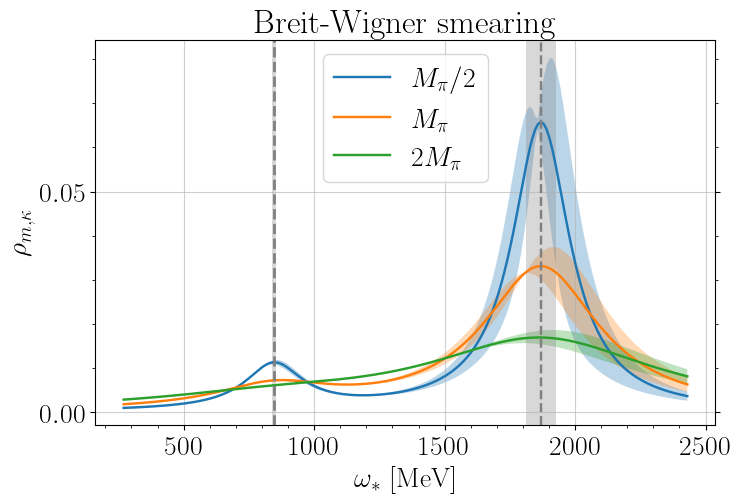

In [154]:
sigma_labels = [r"$M_\pi/2$", r"$M_\pi$", r"$2M_\pi$"]
for ki in range(len(ker)):
    for sigi in range(len(sigma)):
        plt.plot(w/0.065*197.3, rho[ki, sigi, :], label = sigma_labels[sigi])
        plt.fill_between(w/0.065*197.3, rho[ki, sigi, :]-err_rho[ki, sigi, :], rho[ki, sigi, :]+err_rho[ki, sigi, :], alpha = 0.3)
    plt.axvline(par[1]/0.065*197.3, color = "grey", linestyle = "--", alpha = 1, linewidth=2)
    plt.axvspan((par[1] - np.sqrt(cov[1,1]))/0.065*197.3, (par[1] + np.sqrt(cov[1,1]))/0.065*197.3, color = "grey", alpha = 0.3, linewidth=0)
    plt.axvline(par[3]/0.065*197.3, color = "grey", linestyle = "--", alpha = 1)
    plt.axvspan((par[3] - np.sqrt(cov[3,3]))/0.065*197.3, (par[3] + np.sqrt(cov[3,3]))/0.065*197.3, color = "grey", alpha = 0.3, linewidth=0)
    plt.legend()
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\rho_{m, \kappa}$")
    plt.title(ker[ki] + " smearing")
    #plt.tight_layout()
    #plt.ylim(-0.01, 0.25)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    #plt.xticks(fontsize=20)
    #plt.yticks(fontsize=20)
    plt.show()
            

# $\rho(s_\mathrm{max})$

In [150]:
m = 0
ker = ["Breit-Wigner"]
sigma = 270*0.065/197.3
s = [+np.inf, 16, 18]
w = np.linspace(2, 9, 201)*270*0.065/197.3

rho, err_rho = np.zeros((len(ker), len(s), len(w))), np.zeros((len(ker), len(s), len(w)))
for ki in range(len(ker)):
    for si in range(len(s)):
        for wi in range(len(w)):
            if s[si] == +np.inf:
                rho[ki, si, wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma)[0]
            else:
                rho[ki, si, wi] = rho_mellin(w[wi], par, s[si], m, cov, +np.inf, ker=ker[ki], sigma=sigma)[0]
                err_rho[ki, si, wi] = bound_smax(w[wi], s[si], m, par, cov, ker[ki], sigma, +np.inf)[0]

In [151]:
w = np.linspace(3, 3.3, 201)*270*0.065/197.3

rho_zoom, err_rho_zoom = np.zeros((len(ker), len(s), len(w))), np.zeros((len(ker), len(s), len(w)))
for ki in range(len(ker)):
    for si in range(len(s)):
        for wi in range(len(w)):
            if s[si] == +np.inf:
                rho_zoom[ki, si, wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma)[0]
            else:
                rho_zoom[ki, si, wi] = rho_mellin(w[wi], par, s[si], m, cov, +np.inf, ker=ker[ki], sigma=sigma)[0]
                err_rho_zoom[ki, si, wi] = bound_smax(w[wi], s[si], m, par, cov, ker[ki], sigma, +np.inf)[0]

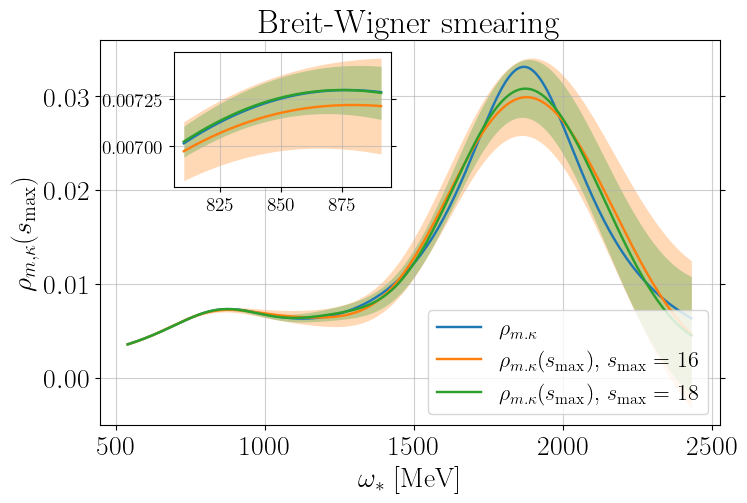

In [152]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8,7))
    w = np.linspace(2, 9, 201)*270*0.065/197.3
    for si in range(len(s)):
        if s[si] == +np.inf:
            plt.plot(w/0.065*197.3, rho[ki, si, :], label = r"$\rho_{m. \kappa}$")
        else:
            line, = plt.plot(w/0.065*197.3, rho[ki, si, :], label = r"$\rho_{m. \kappa}(s_\mathrm{max})$, $s_\mathrm{max} = \,\,$"+r"${}$".format(s[si]))
            plt.fill_between(w/0.065*197.3, rho[ki, si, :]-err_rho[ki, si, :], rho[ki, si, :]+err_rho[ki, si, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    plt.legend(loc="lower right", fontsize = 16)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\rho_{m, \kappa}(s_\mathrm{max})$")
    plt.title(ker[ki] + " smearing", fontsize = 24)
    #plt.tight_layout()
    #b, t = plt.ylim()
    #plt.ylim(0, 0.15)
    ax = plt.gca()
    ins = ax.inset_axes([0.12, 0.62, 0.35, 0.35])
    w = np.linspace(3, 3.3, 201)*270*0.065/197.3
    for si in range(len(s)):
        if s[si] == +np.inf:
            ins.plot(w/0.065*197.3, rho_zoom[ki, si, :], label = r"$\rho_{m. \kappa}$")
        else:
            line, = ins.plot(w/0.065*197.3, rho_zoom[ki, si, :])
            ins.fill_between(w/0.065*197.3, rho_zoom[ki, si, :]-err_rho_zoom[ki, si, :], rho_zoom[ki, si, :]+err_rho_zoom[ki, si, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    ins.tick_params(axis='both', which='major', labelsize=14)
    #ins.set_ylim(0.067, 0.073)
    plt.show()

# $\hat\rho(s_\mathrm{max})$

In [147]:
m = 0
ker = ["Breit-Wigner"]
sigma = 270*0.065/197.3
s = [10]
tmax = [+np.inf, 45, 50]
w = np.linspace(2, 9, 201)*270*0.065/197.3

rho, err_rho = np.zeros((len(ker), len(tmax), len(s), len(w))), np.zeros((len(ker), len(s), len(tmax), len(w)))
for ki in range(len(ker)):
    for ti in range(len(tmax)):
        for si in range(len(s)):
            for wi in range(len(w)):
                rho[ki, ti, si, wi] = rho_mellin(w[wi], par, s[si], m, cov, tmax[ti], ker=ker[ki], sigma=sigma)[0]
        if tmax[ti] != +np.inf:
            for si in range(len(s)):
                for wi in range(len(w)):
                    err_rho[ki, si, ti, wi] = bound_t_rho(w[wi], s[si], tmax[ti], m, par, cov, ker[ki], sigma)[0]
            

In [146]:
m = 0
ker = ["Breit-Wigner"]
sigma = 270*0.065/197.3
s = [10]
tmax = [+np.inf, 45, 50]
w = np.linspace(3, 3.3, 201)*270*0.065/197.3

rho_zoom, err_rho_zoom = np.zeros((len(ker), len(tmax), len(s), len(w))), np.zeros((len(ker), len(s), len(tmax), len(w)))
for ki in range(len(ker)):
    for ti in range(len(tmax)):
        for si in range(len(s)):
            for wi in range(len(w)):
                rho_zoom[ki, ti, si, wi] = rho_mellin(w[wi], par, s[si], m, cov, tmax[ti], ker=ker[ki], sigma=sigma)[0]
        if tmax[ti] != +np.inf:
            for si in range(len(s)):
                for wi in range(len(w)):
                    err_rho_zoom[ki, si, ti, wi] = bound_t_rho(w[wi], s[si], tmax[ti], m, par, cov, ker[ki], sigma)[0]
            

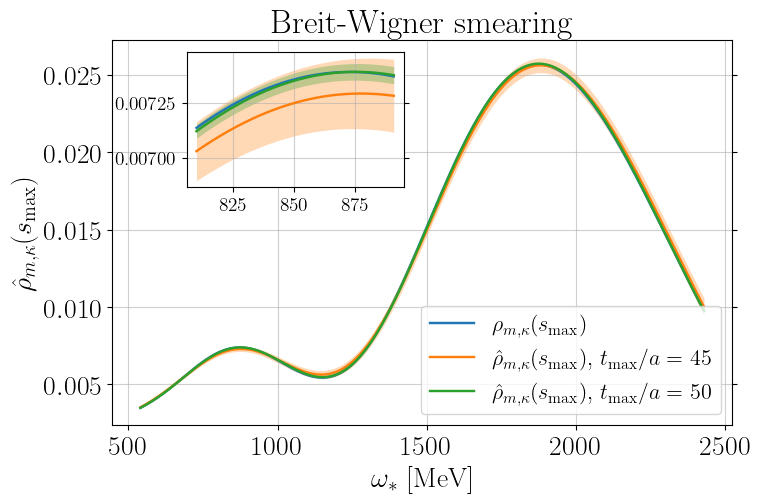

In [149]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8, 7))
    w = np.linspace(2, 9, 201)*270*0.065/197.3
    for si in range(len(s)):
        for ti in range(len(tmax)):
            if tmax[ti] == +np.inf:
                plt.plot(w/0.065*197.3, rho[ki, ti, si, :], label = r"$\rho_{m, \kappa}(s_\mathrm{max})$")
            else:
                line, = plt.plot(w/0.065*197.3, rho[ki, ti, si, :], label = r"$\hat\rho_{m, \kappa}(s_\mathrm{max})$, $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
                plt.fill_between(w/0.065*197.3, rho[ki, ti, si, :]-err_rho[ki, si, ti, :], rho[ki, ti, si, :]+err_rho[ki, si, ti, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    plt.legend(loc='lower right', fontsize=16)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$")
    plt.title(ker[ki] + " smearing", fontsize = 24)
    #plt.tight_layout()
    #b, t = plt.ylim()
    #plt.ylim(0.005, 0.13)

    ax = plt.gca()
    w = np.linspace(3, 3.3, 201)*270*0.065/197.3
    ins = ax.inset_axes([0.12, 0.62, 0.35, 0.35])
    for si in range(len(s)):
        for ti in range(len(tmax)):
            if tmax[ti] == +np.inf:
                ins.plot(w/0.065*197.3, rho_zoom[ki, ti, si, :], label = r"$\rho_{m. \kappa}(s_\mathrm{max})$")
            else:
                line, = ins.plot(w/0.065*197.3, rho_zoom[ki, ti, si, :], label = r"$\hat\rho_{m. \kappa}(s_\mathrm{max})$")
                ins.fill_between(w/0.065*197.3, rho_zoom[ki, ti, si, :]-err_rho_zoom[ki, si, ti, :], rho_zoom[ki, ti, si, :]+err_rho_zoom[ki, si, ti, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    ins.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

In [93]:
M_PI = 270*0.065/197.3
w0 = np.linspace(2, 9, 51)*M_PI
sigma = np.array([1])*M_PI
ker = ["Breit-Wigner"]
rmax = [10]
tmax = [150, 45, 50]
m=0

corr, cov_corr = sample(1, max(tmax), par, cov)
rho = np.zeros((len(ker), len(sigma), len(rmax), len(tmax), len(w0)))
err_rho = np.zeros((len(ker), len(sigma), len(rmax), len(tmax)-1, len(w0)))

for ki in range(len(ker)):
    for sigi in range(len(sigma)):
        for ri in range(len(rmax)):
            for wi in range(len(w0)):
                print("Kernel: {}, sigma = {}, rmax = {}, w0 = {}".format(ker[ki], sigma[sigi]/M_PI, rmax[ri], w0[wi]/M_PI))
                coeff = SDnumpy.rho(w0[wi], corr, rmax[ri], m, ker[ki], sigma[sigi])
                for ti in range(len(tmax)):
                    rho[ki, sigi, ri, ti, wi] = corr[0:tmax[ti]] @ coeff[0:tmax[ti]]
                    if ti != 0:
                        err_rho[ki, sigi, ri, ti-1, wi] = SDnumpy.delta_rho_hat(w0[wi], tmax[ti], par[1], corr[tmax[ti]-1], 200, rmax[ri], m, ker[ki], sigma[sigi])
        if ker[ki] == "None":
            break

Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 2.0
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 2.14
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 2.2800000000000002
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 2.42
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 2.56
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 2.7
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 2.84
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 2.98
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.1199999999999997
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.2600000000000007
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.4000000000000004
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.54
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.68
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.8200000000000007
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.96
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 4.1
Kernel: Breit-Wigner, sigma = 1.0, rm

In [97]:
utils.write_data(rho, [ker, sigma, rmax, tmax, w0], "rho_hat_thesis.txt")
utils.write_data(err_rho, [ker, sigma, rmax, tmax[1:], w0], "delta_rho_hat_thesis.txt")

In [98]:
M_PI = 270*0.065/197.3
w0 = np.linspace(3, 3.3, 51)*M_PI
sigma = np.array([1])*M_PI
ker = ["Breit-Wigner"]
rmax = [10]
tmax = [150, 45, 50]
m=0

corr, cov_corr = sample(1, max(tmax), par, cov)
rho_zoom = np.zeros((len(ker), len(sigma), len(rmax), len(tmax), len(w0)))
err_rho_zoom = np.zeros((len(ker), len(sigma), len(rmax), len(tmax)-1, len(w0)))

for ki in range(len(ker)):
    for sigi in range(len(sigma)):
        for ri in range(len(rmax)):
            for wi in range(len(w0)):
                print("Kernel: {}, sigma = {}, rmax = {}, w0 = {}".format(ker[ki], sigma[sigi]/M_PI, rmax[ri], w0[wi]/M_PI))
                coeff = SDnumpy.rho(w0[wi], corr, rmax[ri], m, ker[ki], sigma[sigi])
                for ti in range(len(tmax)):
                    rho_zoom[ki, sigi, ri, ti, wi] = corr[0:tmax[ti]] @ coeff[0:tmax[ti]]
                    if ti != 0:
                        err_rho_zoom[ki, sigi, ri, ti-1, wi] = SDnumpy.delta_rho_hat(w0[wi], tmax[ti], par[1], corr[tmax[ti]-1], 200, rmax[ri], m, ker[ki], sigma[sigi])
        if ker[ki] == "None":
            break

Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.0
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.006
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.012
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.0180000000000002
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.024
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.03
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.0359999999999996
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.042
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.048
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.054
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.06
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.066
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.072
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.0780000000000003
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.084
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.09
Kernel: Breit-Wigner, sigma = 1.0, rmax = 10, w0 = 3.0

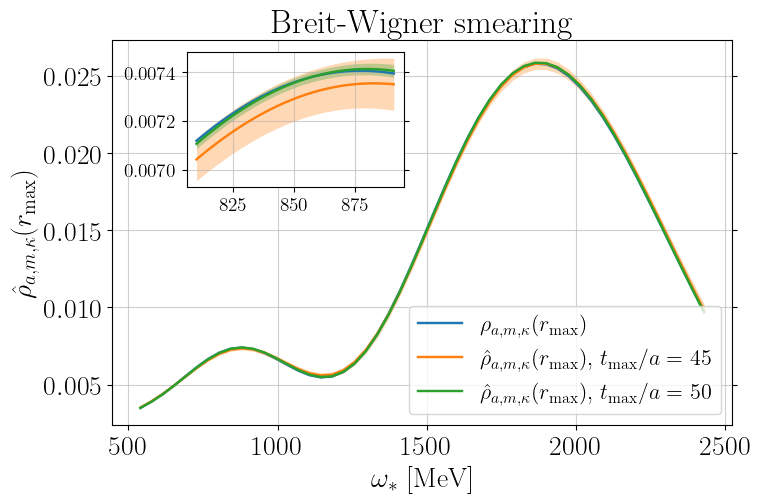

In [106]:
ker = ["Breit-Wigner"]
s = [10]
tmax = [150, 45, 50]

for ki in range(len(ker)):
    #plt.figure(figsize=(8, 7))
    w0 = np.linspace(2, 9, 51)*M_PI
    for si in range(len(s)):
        for ti in range(len(tmax)):
            if tmax[ti] == 150:
                plt.plot(w0/(M_PI/270), rho[ki, 0, si, ti, :], label = r"$\rho_{a, m, \kappa}(r_\mathrm{max})$")
            else:
                line, = plt.plot(w0/(M_PI/270), rho[ki, 0, si, ti, :], label = r"$\hat\rho_{a, m, \kappa}(r_\mathrm{max})$, $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
                plt.fill_between(w0/(M_PI/270), rho[ki, 0, si, ti, :]-err_rho[ki, 0, si, ti-1, :], rho[ki, 0, si, ti, :]+err_rho[ki, 0, si, ti-1, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    plt.legend(loc='lower right', fontsize=16)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\hat{\rho}_{a, m, \kappa}(r_\mathrm{max})$")
    plt.title(ker[ki] + " smearing", fontsize = 24)
    #plt.tight_layout()
    #b, t = plt.ylim()
    #plt.ylim(0.005, 0.135)

    ax = plt.gca()
    w = np.linspace(3, 3.3, 51)*M_PI
    ins = ax.inset_axes([0.12, 0.62, 0.35, 0.35])
    for si in range(len(s)):
        for ti in range(len(tmax)):
            if tmax[ti] == 150:
                ins.plot(w/(M_PI/270), rho_zoom[ki, 0, si, ti, :], label = r"$\rho_{m. \kappa}(s_\mathrm{max})$")
            else:
                line, = ins.plot(w/(M_PI/270), rho_zoom[ki, 0, si, ti, :], label = r"$\hat\rho_{m. \kappa}(s_\mathrm{max})$")
                ins.fill_between(w/(M_PI/270), rho_zoom[ki, 0, si, ti, :]-err_rho_zoom[ki, 0, si, ti-1, :], rho_zoom[ki, 0, si, ti, :]+err_rho_zoom[ki, 0, si, ti-1, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    ins.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

# Optimal $s_\mathrm{max}$

In [138]:
tmax = [47, 95]
brackets = [[9, 10], [15, 20]]
m = 0
ker = ["Breit-Wigner"]
sigma = 270*0.065/197.3
w = np.linspace(2, 9, 201)*270*0.065/197.3

def f(x, w, tmax, m, par, cov, ker, sigma):
    r, er = rho_mellin(w, par, x, m, cov, tmax, ker=ker, sigma=sigma)
    return bound_t_rho(w, x, tmax, m, par, cov, ker, sigma)[0] + bound_smax(w, x, m, par, cov, ker, sigma, tmax)[0] + er

smax = np.zeros((len(ker), len(tmax), len(w)))
for ki in range(len(ker)):
    for ti in range(len(tmax)):
        for wi in range(len(w)):
            print(ker[ki], tmax[ti], w[wi]/0.065*197.3)
            f_wrap = lambda x: f(x, w[wi], tmax[ti], m, par, cov, ker[ki], sigma)
            #for si in np.linspace(10, 20, 10):
            #    print(f_wrap(si))
            smax[ki, ti, wi] = minimize_scalar(f_wrap, bracket=brackets[ti]).x
        

Breit-Wigner 47 540.0
Breit-Wigner 47 549.4500000000002
Breit-Wigner 47 558.8999999999999
Breit-Wigner 47 568.35
Breit-Wigner 47 577.8000000000001
Breit-Wigner 47 587.25
Breit-Wigner 47 596.7000000000002
Breit-Wigner 47 606.15
Breit-Wigner 47 615.6
Breit-Wigner 47 625.05
Breit-Wigner 47 634.5
Breit-Wigner 47 643.9499999999999
Breit-Wigner 47 653.4
Breit-Wigner 47 662.85
Breit-Wigner 47 672.3000000000002
Breit-Wigner 47 681.7499999999999
Breit-Wigner 47 691.2
Breit-Wigner 47 700.6500000000001
Breit-Wigner 47 710.1
Breit-Wigner 47 719.55
Breit-Wigner 47 729.0000000000001
Breit-Wigner 47 738.45
Breit-Wigner 47 747.9
Breit-Wigner 47 757.3499999999999
Breit-Wigner 47 766.8
Breit-Wigner 47 776.2500000000001
Breit-Wigner 47 785.6999999999999
Breit-Wigner 47 795.1500000000002
Breit-Wigner 47 804.6000000000001
Breit-Wigner 47 814.0500000000002
Breit-Wigner 47 823.5
Breit-Wigner 47 832.9499999999999
Breit-Wigner 47 842.4
Breit-Wigner 47 851.8500000000001
Breit-Wigner 47 861.3000000000001
Breit-W

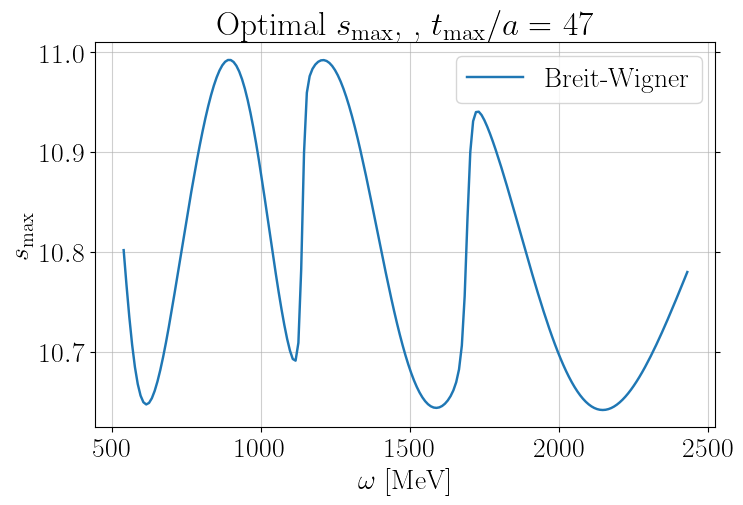

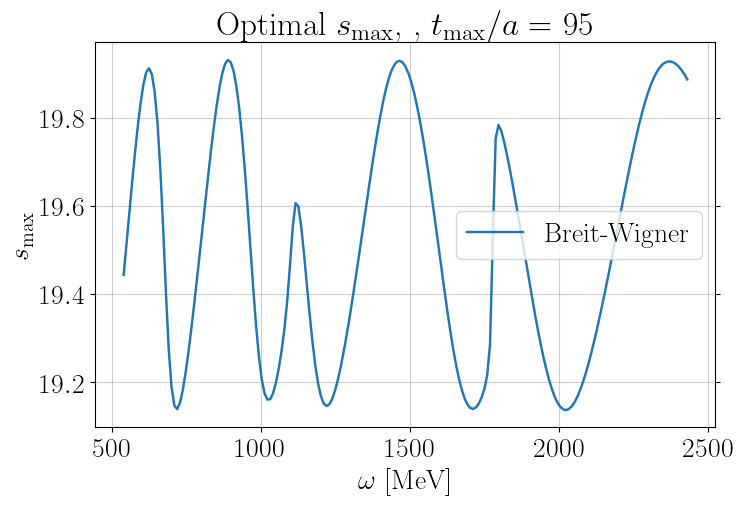

In [139]:
for ti in range(len(tmax)):
    plt.plot(w/0.065*197.3, smax[0, ti, :], label = r"Breit-Wigner")
    plt.xlabel(r"$\omega$ [MeV]")
    plt.ylabel(r"$s_\mathrm{max}$")
    plt.legend()
    plt.title(r"Optimal $s_\mathrm{max}$, , $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
    plt.show()

In [143]:
rho, err_rho = np.zeros((len(ker), len(tmax), len(w))), np.zeros((len(ker), len(tmax), len(w)))
for ki in range(len(ker)):
    print(ker[ki])
    for ti in range(len(tmax)):
        for wi in range(len(w)):
            rho[ki, ti, wi] , stat = rho_mellin(w[wi], par, smax[ki, ti, wi], m, cov, tmax[ti], ker=ker[ki], sigma=sigma)
            sys = bound_t_rho(w[wi], smax[ki, ti, wi], tmax[ti], m, par, cov, ker[ki], sigma)[0] + bound_smax(w[wi], smax[ki, ti, wi], m, par, cov, ker[ki], sigma, tmax[ti])[0]
            err_rho[ki, ti, wi] = stat + sys

Breit-Wigner


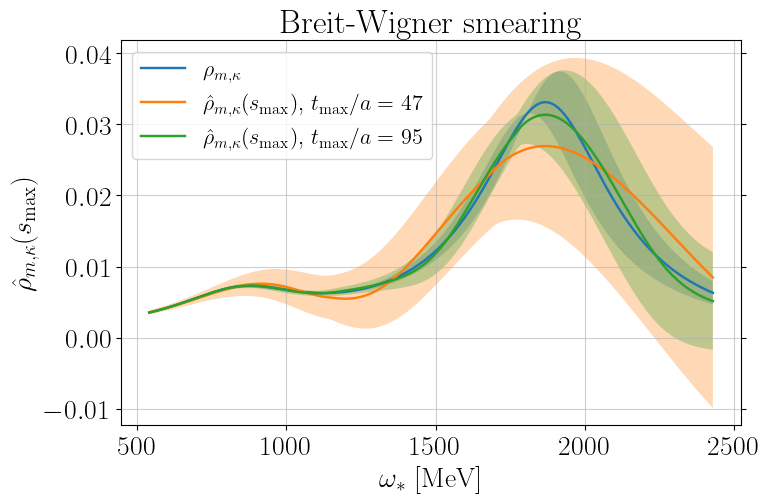

In [144]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8,7))
    ex, err_ex = np.zeros(len(w)), np.zeros(len(w))
    for wi in range(len(w)):
        ex[wi], err_ex[wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma)
    plt.plot(w/0.065*197.3, ex, label = r"$\rho_{m, \kappa}$")
    plt.fill_between(w/0.065*197.3, ex-err_ex, ex+err_ex, alpha = 0.3)
    for ti in range(len(tmax)):
        plt.plot(w/0.065*197.3, rho[ki, ti, :], label = r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$, $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
        plt.fill_between(w/0.065*197.3, rho[ki, ti, :] - err_rho[ki, ti, :], rho[ki, ti, :] + err_rho[ki, ti, :], alpha = 0.3)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$")
    plt.legend(fontsize=16)
    plt.title(ker[ki] + " smearing")
    #plt.ylim(-0.07, 0.155)
    plt.show()

In [124]:
tmax = [47, 95]
s = [9, 18]
m = 0
ker = ["Breit-Wigner"]
sigma = np.linspace(1, 2.5, 201)*270*0.065/197.3
w = np.linspace(2, 9, 201)*270*0.065/197.3

rho, err_rho = np.zeros((len(ker), len(tmax), len(w))), np.zeros((len(ker), len(tmax), len(w)))
for ki in range(len(ker)):
    print(ker[ki])
    for ti in range(len(tmax)):
        for wi in range(len(w)):
            rho[ki, ti, wi] , stat = rho_mellin(w[wi], par, s[ti], m, cov, tmax[ti], ker=ker[ki], sigma=sigma[wi])
            sys = bound_t_rho(w[wi], s[ti], tmax[ti], m, par, cov, ker[ki], sigma[wi])[0] + bound_smax(w[wi], s[ti], m, par, cov, ker[ki], sigma[wi], tmax[ti])[0]
            err_rho[ki, ti, wi] = stat + sys

Breit-Wigner


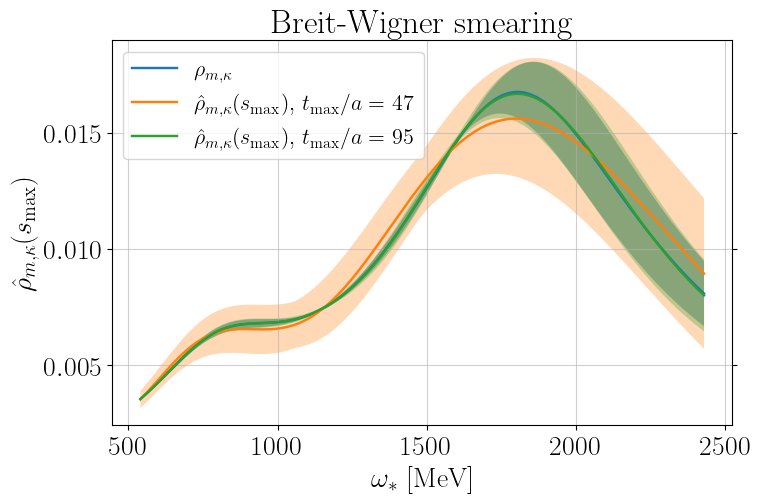

In [125]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8,7))
    ex, err_ex = np.zeros(len(w)), np.zeros(len(w))
    for wi in range(len(w)):
        ex[wi], err_ex[wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma[wi])
    plt.plot(w/0.065*197.3, ex, label = r"$\rho_{m, \kappa}$")
    plt.fill_between(w/0.065*197.3, ex-err_ex, ex+err_ex, alpha = 0.5)
    for ti in range(len(tmax)):
        plt.plot(w/0.065*197.3, rho[ki, ti, :], label = r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$, $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
        plt.fill_between(w/0.065*197.3, rho[ki, ti, :] - err_rho[ki, ti, :], rho[ki, ti, :] + err_rho[ki, ti, :], alpha = 0.3)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$")
    plt.legend(fontsize=16)
    plt.title(ker[ki] + " smearing")
    #plt.ylim(-0.005, 0.11)
    plt.show()

In [131]:
tmax = [47, 95]
rmax = [9, 18]
m = 0
ker = ["Breit-Wigner"]
sigma = np.linspace(1, 2.5, 51)*270*0.065/197.3
w0 = np.linspace(2, 9, 51)*270*0.065/197.3

corr, cov_corr = sample(1, max(tmax), par, cov)
rho, err_rho = np.zeros((len(ker), len(tmax), len(w0))), np.zeros((len(ker), len(tmax), len(w0)))

scan = np.linspace(7.5, 8.5, 251)
mell = np.zeros((len(scan)))
for xi in range(len(scan)):
    mell[xi] = np.abs(SDmpmath.mellin(scan[xi], m, corr)/sp.special.gamma(0.5+1j*scan[xi]))
max_mell = max(mell)

for ki in range(len(ker)):
    for wi in range(len(w0)):
        for ti in range(len(tmax)):
            print("Kernel: {}, tmax = {}, w0 = {}".format(ker[ki], tmax[ti], w0[wi]/M_PI))
            coeff = SDnumpy.rho(w0[wi], corr[0:tmax[ti]], rmax[ti], m, ker[ki], sigma[wi])    
            rho[ki, ti, wi] = corr[0:tmax[ti]] @ coeff[0:tmax[ti]]
            stat = np.sqrt(coeff[0:tmax[ti]].T @ cov_corr[0:tmax[ti], 0:tmax[ti]] @ coeff[0:tmax[ti]])
            sys =  SDnumpy.delta_rho_hat(w0[wi], tmax[ti], par[1], corr[tmax[ti]-1], 200, rmax[ti], m, ker[ki], sigma[wi]) +\
                    max_mell * mp.fp.quad(lambda s: np.abs(kernels_mellin[ker[ki]](s, w0[wi], sigma[wi])), [rmax[ti], +np.inf])
            err_rho[ki, ti, wi] = stat + sys

Kernel: Breit-Wigner, tmax = 47, w0 = 2.0
Kernel: Breit-Wigner, tmax = 95, w0 = 2.0
Kernel: Breit-Wigner, tmax = 47, w0 = 2.14
Kernel: Breit-Wigner, tmax = 95, w0 = 2.14
Kernel: Breit-Wigner, tmax = 47, w0 = 2.2800000000000002
Kernel: Breit-Wigner, tmax = 95, w0 = 2.2800000000000002
Kernel: Breit-Wigner, tmax = 47, w0 = 2.42
Kernel: Breit-Wigner, tmax = 95, w0 = 2.42
Kernel: Breit-Wigner, tmax = 47, w0 = 2.56
Kernel: Breit-Wigner, tmax = 95, w0 = 2.56
Kernel: Breit-Wigner, tmax = 47, w0 = 2.7
Kernel: Breit-Wigner, tmax = 95, w0 = 2.7
Kernel: Breit-Wigner, tmax = 47, w0 = 2.84
Kernel: Breit-Wigner, tmax = 95, w0 = 2.84
Kernel: Breit-Wigner, tmax = 47, w0 = 2.9800000000000004
Kernel: Breit-Wigner, tmax = 95, w0 = 2.9800000000000004
Kernel: Breit-Wigner, tmax = 47, w0 = 3.1199999999999997
Kernel: Breit-Wigner, tmax = 95, w0 = 3.1199999999999997
Kernel: Breit-Wigner, tmax = 47, w0 = 3.2600000000000007
Kernel: Breit-Wigner, tmax = 95, w0 = 3.2600000000000007
Kernel: Breit-Wigner, tmax = 47,

In [136]:
utils.write_data(rho, [ker, tmax, w0], "rho_opt_thesis.txt")
utils.write_data(err_rho, [ker, tmax, w0], "delta_rho_opt_thesis.txt")

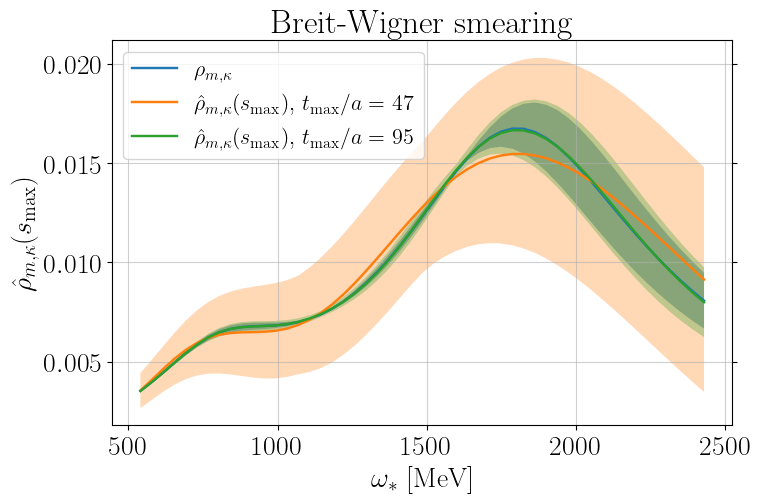

In [134]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8,7))
    ex, err_ex = np.zeros(len(w0)), np.zeros(len(w0))
    for wi in range(len(w0)):
        ex[wi], err_ex[wi] = SD_2exp.rho(w0[wi], m, par, cov, ker[ki], sigma[wi])
    plt.plot(w0/0.065*197.3, ex, label = r"$\rho_{m, \kappa}$")
    plt.fill_between(w0/0.065*197.3, ex-err_ex, ex+err_ex, alpha = 0.5)
    for ti in range(len(tmax)):
        plt.plot(w0/0.065*197.3, rho[ki, ti, :], label = r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$, $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
        plt.fill_between(w0/0.065*197.3, rho[ki, ti, :] - err_rho[ki, ti, :], rho[ki, ti, :] + err_rho[ki, ti, :], alpha = 0.3)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$")
    plt.legend(fontsize=16)
    plt.title(ker[ki] + " smearing")
    #plt.ylim(-0.005, 0.11)
    plt.show()